# Convoluted neural network to predict handwritten digits

## 1. Introduction

In this notebook I use a 5-layer sequential convoluted neural network for digits recognition trained on the  MNIST dataset. I use Keras with a Tensorflow backend.

In [8]:
import keras
print('Keras version :', keras.__version__, '\n')

#check Tensorflow recognizes GPU
from tensorflow.python.client import device_lib
print('List of available devices :\n', device_lib.list_local_devices())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
import os

Keras version : 2.2.4 

List of available devices :
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3535457405334307738
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4957247897
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1160660646156901785
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## 2. Data preparation
### 2.1 Load data

In [40]:
#train is 42,000 x 785 and first column is label
train = pd.read_csv('train.csv')
Y = train['label']
X = train.drop(labels=['label'], axis=1)
del train #free some space

#test is 28,000 x 784
test = pd.read_csv('test.csv')

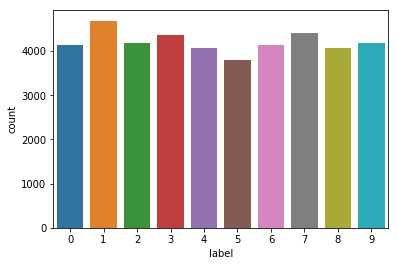

In [20]:
g = sns.countplot(Y_train)

### 2.2 Check for null and missing values
I check for corrupted images, which would have missing values for one or more pixels. For the following instruction we expect to see only one unique value: False.

In [41]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Normalization
We perform a greyscale normalization to reduce the effect of differences in illumination. Moreover, the convoluted neural network will converge faster on data between 0 and 1 than on data between 0 and 255.

In [42]:
X_norm = X / 255
test_norm = test / 255

### 2.4 Reshape and label encoding
Train and test images are 28 x 28 images stored in pandas dataframes as 1D vectors containing 784 values. I reshape the data as 28 x 28 x 1 3D matrices. The last dimension corresponds to a channel, since Keras requires this. The MNIST images are grey-scale images so I use only one channel. RGB images would have 3 channels, so 28 x 28 x 3. Finally, the images represent 10 digits from 0 to 9, and I encode the labels as one-hot vectors.

In [43]:
#reshape into numpy arrays
X_rs = X_norm.values.reshape(-1, 28, 28, 1)
test_rs = test_norm.values.reshape(-1, 28, 28, 1)

#one-hot label encoding
Y_hot = keras.utils.np_utils.to_categorical(Y, num_classes=10)

### 2.5 Split data into training and cross-validation datasets
We choose a cross-validation set size of 10 % of data, the rest is used to train the model. The labels all have similar frequencies so we do a random split. This may not be a good choice if the labels are heavily skewed since validation could be inaccurate. To prevent this from happening, I could use the option *stratify=True* in *train_test_split*. Let's also have a look at one image.

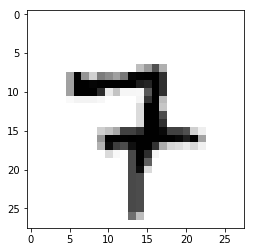

In [46]:
#split data
X_train, X_cv, Y_train, Y_cv = train_test_split(X_rs, Y_hot, test_size=0.1)

#show example
g = plt.imshow(X_train[0][:, :, 0], cmap='Greys')

## 3. A convoluted neural network model
### 3.1 Model definition